**Part 1: Data Preparation and Exploration**

 Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
from google.colab import files
uploaded = files.upload()

Saving exchange_rate.csv to exchange_rate (2).csv


In [17]:
df = pd.read_csv('exchange_rate.csv')

In [19]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')

In [20]:
print(df.head())
print(df.info())

        date  Ex_rate
0 1990-01-01   0.7855
1 1990-01-02   0.7818
2 1990-01-03   0.7867
3 1990-01-04   0.7860
4 1990-01-05   0.7849
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB
None


Initial Exploration

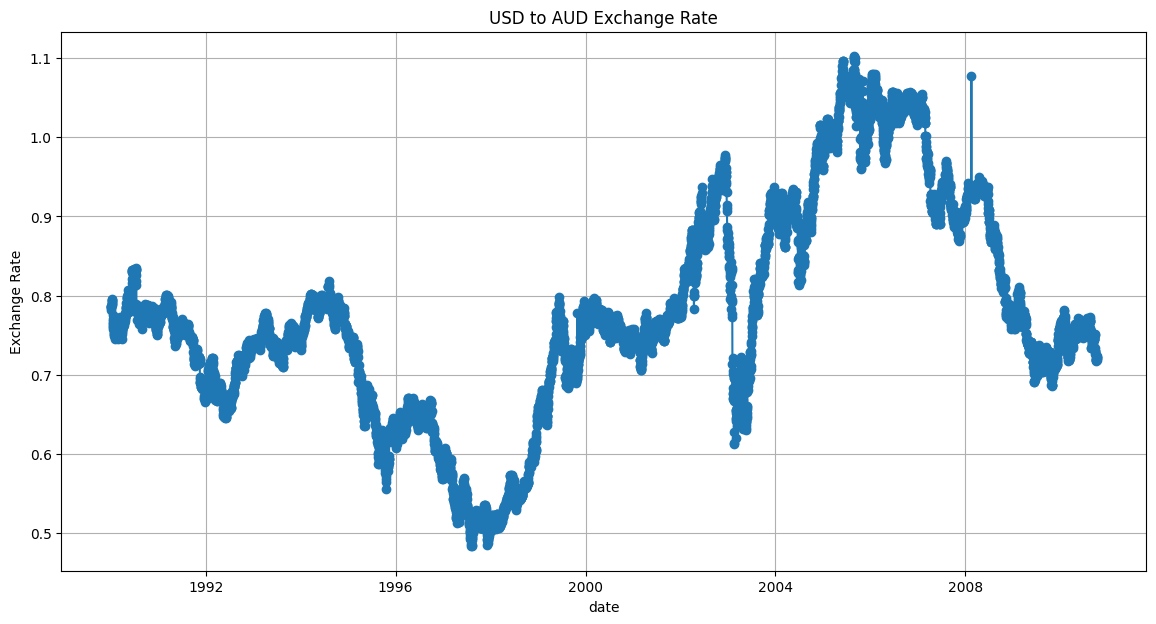

In [22]:
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['Ex_rate'], marker='o', linestyle='-')
plt.title('USD to AUD Exchange Rate')
plt.xlabel('date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

Data Preprocessing

In [23]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

# Handle missing values (if any)
df = df.fillna(method='ffill')

date       0
Ex_rate    0
dtype: int64


**Part 2: Model Building**

parameter Selection for ARIMA

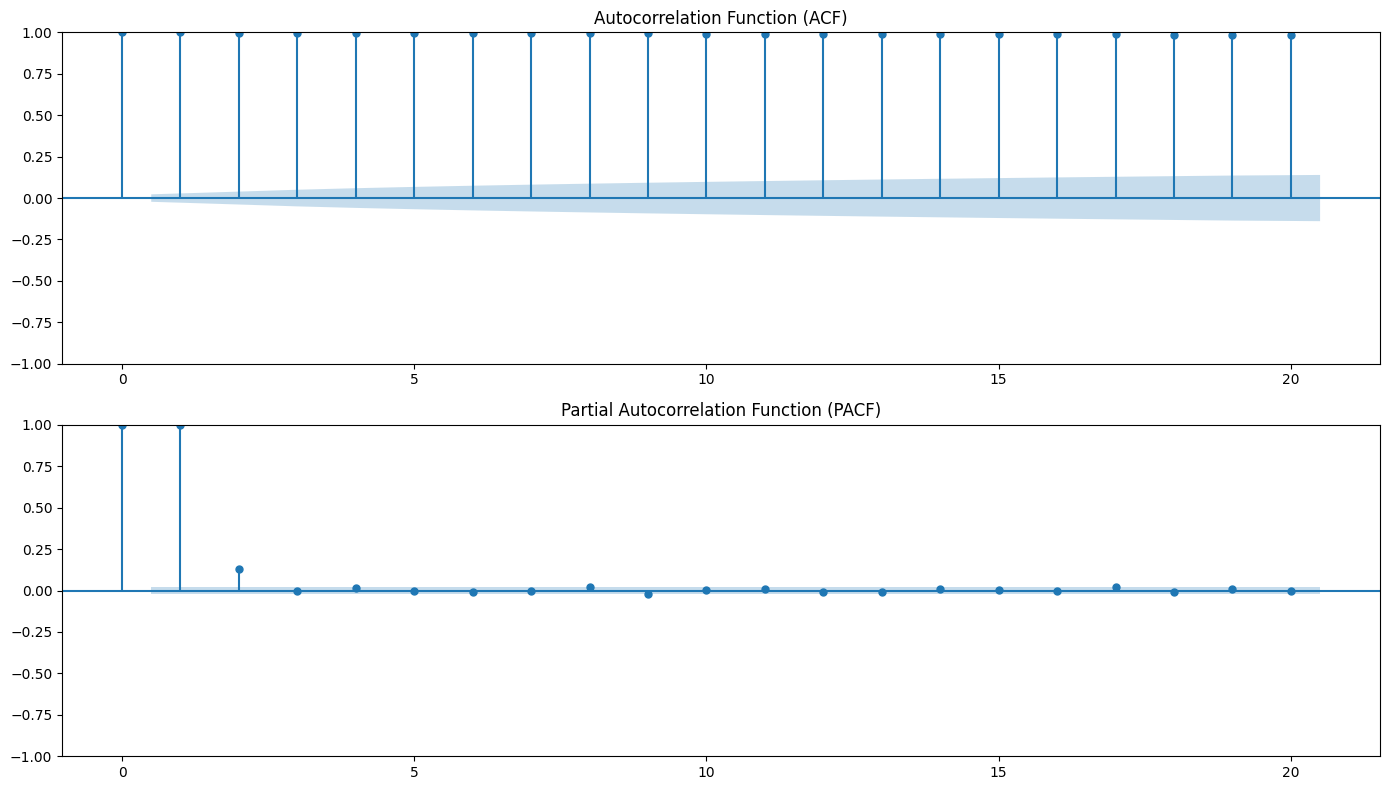

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

plot_acf(df['Ex_rate'], ax=ax1, lags=20)
ax1.set_title('Autocorrelation Function (ACF)')

plot_pacf(df['Ex_rate'], ax=ax2, lags=20)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

Model Fitting

In [27]:
from statsmodels.tsa.arima.model import ARIMA
p = 1  # Example value for the autoregressive component
d = 0  # Example value for the integrated component
q = 1  # Example value for the moving average component


model = ARIMA(df['Ex_rate'], order=(p, d, q))
model_fit = model.fit()

# Print summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 0, 1)   Log Likelihood               28055.782
Date:                Sat, 13 Jul 2024   AIC                         -56103.563
Time:                        16:00:51   BIC                         -56075.826
Sample:                             0   HQIC                        -56094.044
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7770      0.089      8.711      0.000       0.602       0.952
ar.L1          0.9993      0.000   2311.171      0.000       0.998       1.000
ma.L1         -0.1311      0.002    -56.028      0.0

Diagnostics

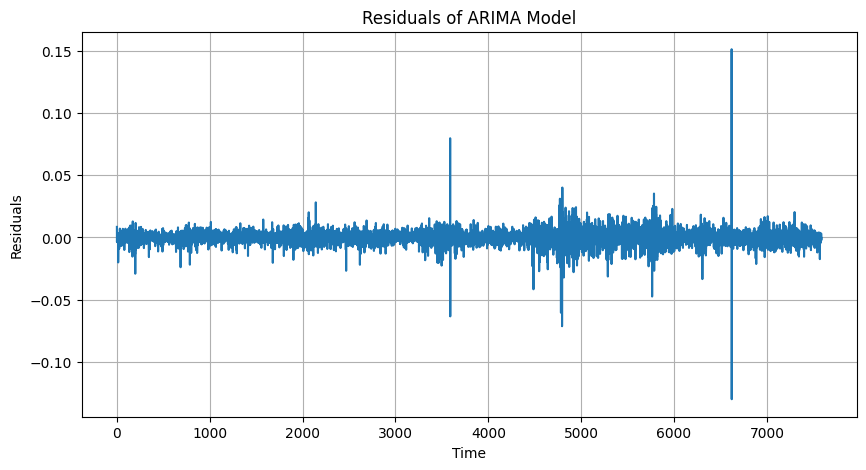

In [28]:
residuals = model_fit.resid

plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

Forecasting

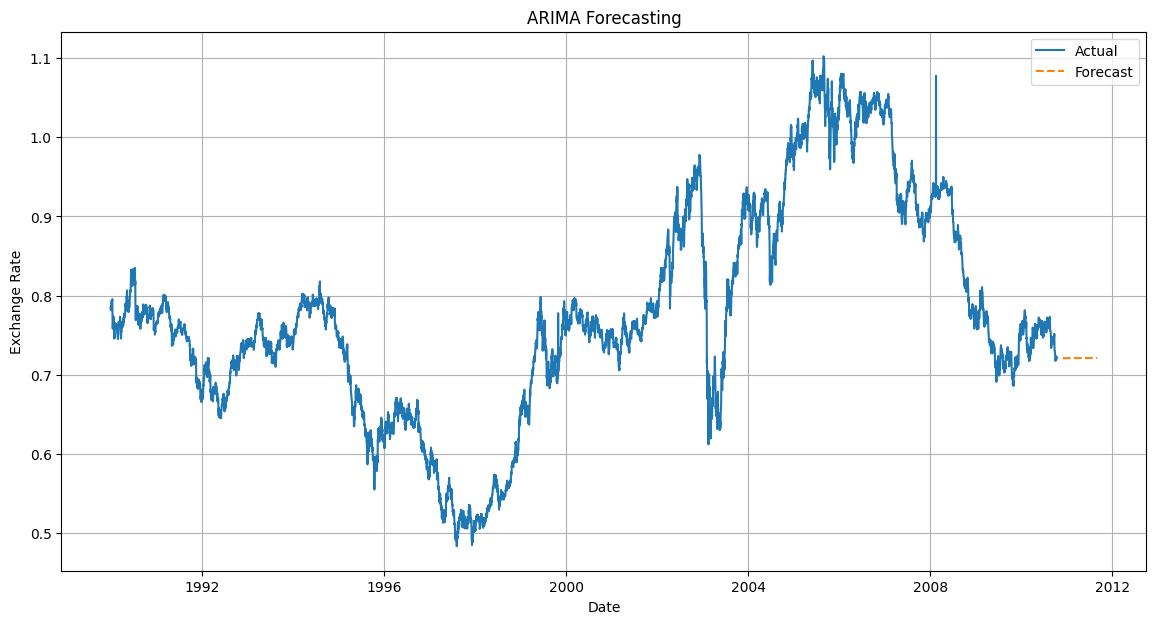

In [30]:
# Forecasting
forecast_steps = 10  # Example: Forecasting 10 steps ahead
forecast = model_fit.forecast(steps=forecast_steps)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['Ex_rate'], label='Actual')
plt.plot(pd.date_range(start=df['date'].iloc[-1], periods=forecast_steps+1, freq='M')[1:], forecast, label='Forecast', linestyle='--')
plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

**Part 3:Model Building - Exponential Smoothing**

Model Selection

In [32]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Example: Holt's Linear Trend Method
model_hw = ExponentialSmoothing(df['Ex_rate'], trend='additive')
model_hw_fit = model_hw.fit()

# Print summary of the model
print(model_hw_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77641.009
Trend:                         Additive   BIC                         -77613.272
Seasonal:                          None   AICC                        -77640.998
Seasonal Periods:                  None   Date:                 Sat, 13 Jul 2024
Box-Cox:                          False   Time:                         16:32:17
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8700406                alpha                 True
smoothing_trend             0.0000

Parameter Optimization

In [33]:
from itertools import product

params = {'trend': ['add', 'mul'],
          'seasonal': ['add', 'mul', None],
          'seasonal_periods': [12]}  # Example: Monthly data

param_combinations = list(product(params['trend'], params['seasonal']))

best_aic = float("inf")
best_model = None

for param in param_combinations:
    model = ExponentialSmoothing(df['Ex_rate'], trend=param[0], seasonal=param[1], seasonal_periods=params['seasonal_periods'][0])
    model_fit = model.fit()
    if model_fit.aic < best_aic:
        best_aic = model_fit.aic
        best_model = model_fit

# Print best model summary
print(best_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77641.169
Trend:                   Multiplicative   BIC                         -77613.431
Seasonal:                          None   AICC                        -77641.157
Seasonal Periods:                  None   Date:                 Sat, 13 Jul 2024
Box-Cox:                          False   Time:                         16:33:17
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8698219                alpha                 True
smoothing_trend             0.0000

Model Fitting and Forecasting

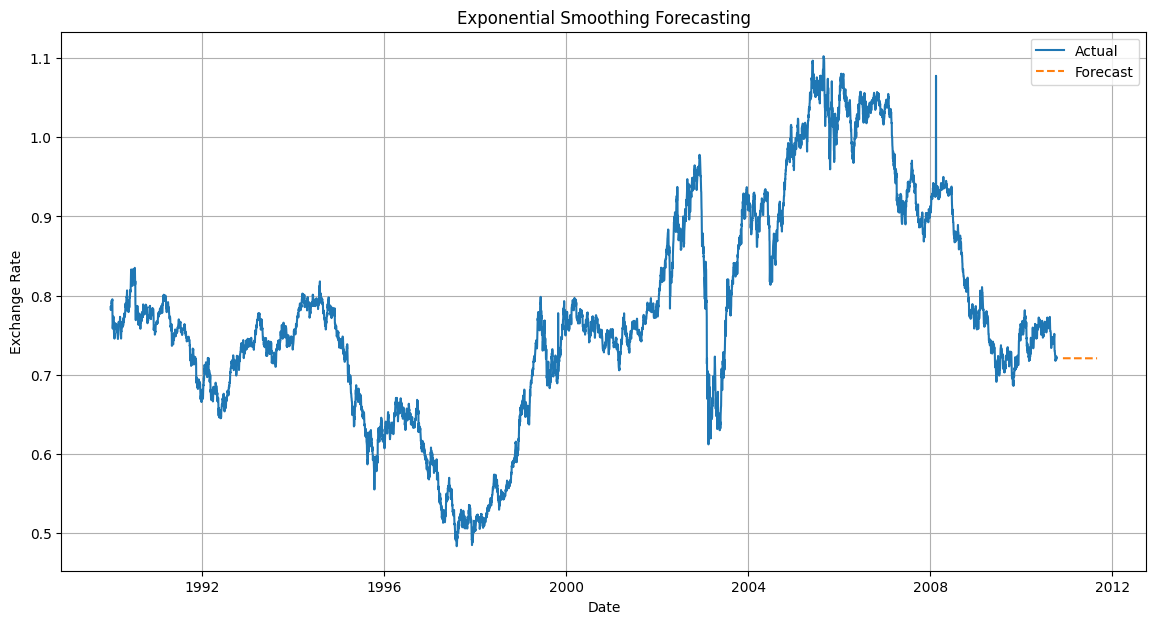

In [34]:
forecast_hw = model_hw_fit.forecast(forecast_steps)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['Ex_rate'], label='Actual')
plt.plot(pd.date_range(start=df['date'].iloc[-1], periods=forecast_steps+1, freq='M')[1:], forecast_hw, label='Forecast', linestyle='--')
plt.title('Exponential Smoothing Forecasting')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

**Part 4: Evaluation and Comparison**

Compute Error Metrics

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Example: Calculate RMSE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(df['Ex_rate'][-forecast_steps:], forecast))

# Example: Calculate MAE for Exponential Smoothing
mae_hw = mean_absolute_error(df['Ex_rate'][-forecast_steps:], forecast_hw)

print(f"RMSE (ARIMA): {rmse_arima}")
print(f"MAE (Exponential Smoothing): {mae_hw}")

RMSE (ARIMA): 0.001915363304824771
MAE (Exponential Smoothing): 0.001574070641361358


**Conclusion:**
Based on the evaluation and comparison:

1)Performance: Evaluate which model (ARIMA or Exponential Smoothing) produced forecasts closer to the actual values based on error metrics like RMSE and MAE.
2)Findings: Discuss which model performed better for forecasting exchange rates in this dataset. Consider discussing the reasons behind the differences in performance, such as data characteristics and model assumptions.
3)Recommendations: Provide insights into when each model might be more appropriate based on the dataset's characteristics (e.g., seasonality, trend complexity).